### Download Dependencies

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim



In [2]:

def GPUcheck():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"CUDA device is available: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print("MPS device is available (Apple Silicon).")
    else:
        device = torch.device("cpu")
        print("Neither CUDA nor MPS found, using CPU.")
        print(f"MPS built: {torch.backends.mps.is_built()}")
        


In [3]:
device = torch.device("cuda")

### Load Data

In [4]:
train_dir = './train_images'    # folder containing training images
test_dir = './test_images'    # folder containing test images

In [5]:
transform = transforms.Compose(
    [transforms.Grayscale(),   # transforms to gray-scale (1 input channel)
     transforms.ToTensor(),    # transforms to Torch tensor (needed for PyTorch)
     transforms.Normalize(mean=(0.5,),std=(0.5,))]) # subtracts mean (0.5) and devides by standard deviation (0.5) -> resulting values in (-1, +1)

# Define two pytorch datasets (train/test) 
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=transform)

valid_size = 0.2   # proportion of validation set (80% train, 20% validation)
batch_size = 32  

In [6]:
# Define randomly the indices of examples to use for training and for validation
num_train = len(train_data)
indices_train = list(range(num_train))
np.random.shuffle(indices_train)
split_tv = int(np.floor(valid_size * num_train))
train_new_idx, valid_idx = indices_train[split_tv:],indices_train[:split_tv]

# Define two "samplers" that will randomly pick examples from the training and validation set
train_sampler = SubsetRandomSampler(train_new_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Dataloaders (take care of loading the data from disk, batch by batch, during training)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=1)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=1)

classes = ('noface','face')  # indicates that "1" means "face" and "0" non-face (only used for display)


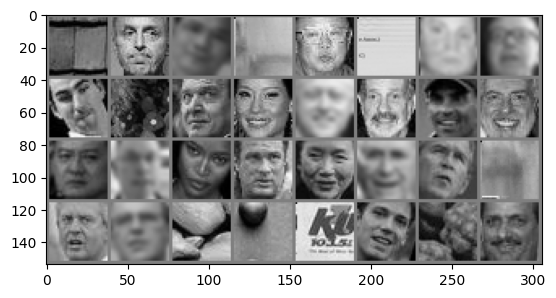

noface face  face  noface face  noface face  face  face  noface face  face  face  face  face  face  face  face  face  face  face  face  face  noface face  face  noface noface noface face  noface face 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define CNN

In [8]:
def get_resnet50(num_classes):
    # Load pre-trained ResNet-50
    model = models.resnet50(pretrained=True)

    # Replace the first convolutional layer to accept 1 channel
    original_conv1 = model.conv1
    model.conv1 = nn.Conv2d(
        in_channels=1,  # Change input channels to 1 for grayscale
        out_channels=original_conv1.out_channels,  # Retain original output channels
        kernel_size=original_conv1.kernel_size,
        stride=original_conv1.stride,
        padding=original_conv1.padding,
        bias=original_conv1.bias
    )
    
    # Copy the weights from the original layer (average across the RGB channels)
    with torch.no_grad():
        model.conv1.weight[:] = original_conv1.weight.mean(dim=1, keepdim=True)
    
    
    # Replace the final fully connected layer for your specific task
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    
    return model

In [9]:
num_classes = len(classes)  # Number of classes in your dataset
model1 = get_resnet50(num_classes)

c:\Users\andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\andrea\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# def eval_accuracy(valid_loader, model, device):
#     model.eval()
#     valid_correct = 0
#     valid_total = 0
#     valid_loss = 0
#     criterion = nn.CrossEntropyLoss()

#     with torch.no_grad():
#         for data, target in valid_loader:
#             data, target = data.to(device), target.to(device)
#             output = model(data)
#             _, predicted = torch.max(output, 1)
#             valid_total += target.size(0)
#             valid_correct += (predicted == target).sum().item()
#             loss = criterion(output, target)
#             valid_loss += loss.item()

#     valid_accuracy = (100 * valid_correct / valid_total)
#     print(f'Validation Accuracy: {valid_accuracy:.2f}% / Validation Loss: {valid_loss:.2f}')
#     return valid_accuracy, valid_loss



In [11]:
def evaluate(loader, model, device, criterion, mode="Validation"):
    """
    Evaluate the model's accuracy and loss on a given dataset.

    Parameters:
        loader (DataLoader): Dataset loader (e.g., train_loader or valid_loader).
        model (nn.Module): The model to evaluate.
        device (torch.device): The device (CPU or GPU) to use.
        criterion (Loss): Loss function (e.g., CrossEntropyLoss).
        mode (str): Mode of evaluation ("Validation" or "Training").

    Returns:
        float: Accuracy of the model on the dataset (percentage).
        float: Average loss of the model on the dataset.
    """
    model.eval()
    total_correct = 0
    total_samples = 0
    total_loss = 0
    

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)  # Get predictions
            total_samples += target.size(0)
            total_correct += (predicted == target).sum().item()
            loss = criterion(output, target)
            total_loss += loss.item()

    accuracy = 100 * total_correct / total_samples
    avg_loss = total_loss / len(loader)
    print(f"{mode} Accuracy: {accuracy:.2f}% / {mode} Loss: {avg_loss:.4f}")
    return accuracy, avg_loss


In [12]:
def train(train_loader, valid_loader, device, n_epochs, model, criterion, optimizer):
    tr_loss = []  # To store average training loss for each epoch
    val_loss = []  # To store average validation loss for each epoch
    tr_acc = []   # To store training accuracy for each epoch
    val_acc = []   # To store validation accuracy for each epoch

    # loop over epochs: one epoch = one pass through the whole training dataset
    for epoch in range(1, n_epochs+1):  
        #   loop over iterations: one iteration = 1 batch of examples
        i = 0
        for data, target in train_loader:
            model.train()
            i += 1
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            if i % (int(len(train_loader)/10)+1) == 0:
                model.eval()
                evaluate(valid_loader,model,device,criterion, "Validation")
                print("-------------------------------------",np.round(i/len(train_loader)*100,2),"% complete")
            
        print(f"============================= epoch {epoch} done out of {n_epochs} !!")
        model.eval()
        valacc, valloss = evaluate(valid_loader,model, device, criterion, "Validation")
        val_acc.append(valacc)
        val_loss.append(valloss)
        tracc, trloss = evaluate(train_loader, model, device, criterion, "Training")
        tr_acc.append(tracc)
        tr_loss.append(trloss)
        print("\n")

    return tr_loss, val_loss, tr_acc, val_acc


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
    # model1 = model1.to(device)
    # criterion = nn.CrossEntropyLoss().to(device)
    # optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    # n_epochs = 10# Set the number of epochs

    # # Train the model
    # train(train_loader, valid_loader,device, n_epochs, model1, criterion, optimizer)

In [15]:
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
n_epochs = 5# Set the number of epochs




In [16]:
# Train the model
train_loss, valid_loss, train_acc, valid_acc = train(
    train_loader, valid_loader, device, n_epochs, model1, criterion, optimizer
)


Validation Accuracy: 94.35% / Validation Loss: 0.1413
------------------------------------- 10.03 % complete
Validation Accuracy: 98.56% / Validation Loss: 0.0395
------------------------------------- 20.06 % complete
Validation Accuracy: 98.83% / Validation Loss: 0.0331
------------------------------------- 30.09 % complete
Validation Accuracy: 99.11% / Validation Loss: 0.0270
------------------------------------- 40.12 % complete
Validation Accuracy: 99.29% / Validation Loss: 0.0196
------------------------------------- 50.15 % complete
Validation Accuracy: 99.17% / Validation Loss: 0.0203
------------------------------------- 60.18 % complete
Validation Accuracy: 99.49% / Validation Loss: 0.0158
------------------------------------- 70.21 % complete
Validation Accuracy: 99.45% / Validation Loss: 0.0164
------------------------------------- 80.24 % complete
Validation Accuracy: 99.42% / Validation Loss: 0.0167
------------------------------------- 90.27 % complete
===================

In [17]:

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(valid_loader, model, device, classes):
    model.eval()
    valid_labels = []
    valid_preds = []

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            valid_labels.extend(target.cpu().numpy())
            valid_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(valid_labels, valid_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()



# visualize :

import matplotlib.pyplot as plt

def plot_training_curves(train_loss, valid_loss, train_acc, valid_acc, n_epochs):
    epoch_list = range(1, n_epochs + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epoch_list, train_loss, label='train loss', color='tab:blue')
    plt.plot(epoch_list, valid_loss, label='validation loss', color='tab:orange')
    plt.title('Loss Trend')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(epoch_list, train_acc, label='train accuracy', color='tab:blue')
    plt.plot(epoch_list, valid_acc, label='validation accuracy', color='tab:orange')
    plt.title('Accuracy Trend')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()



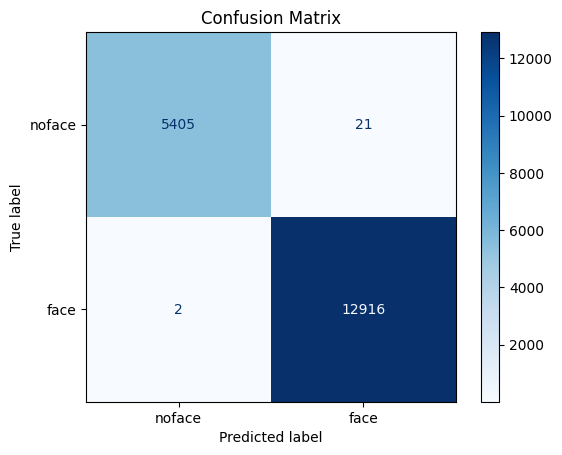

In [18]:
plot_confusion_matrix(valid_loader, model1, device, classes)


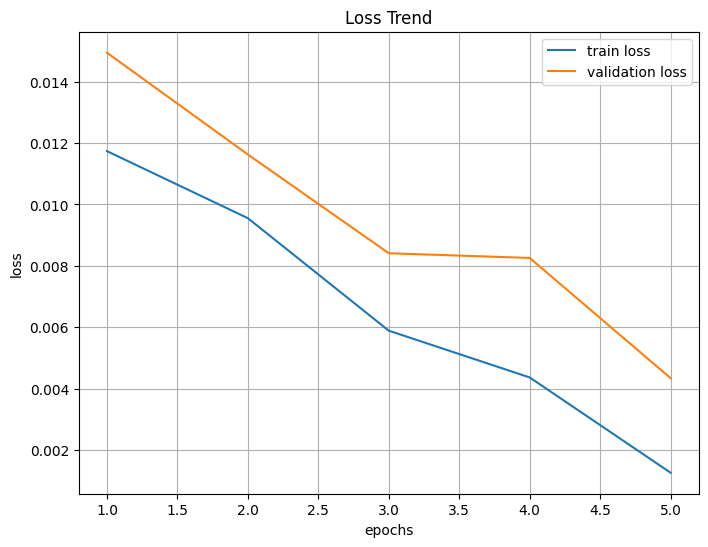

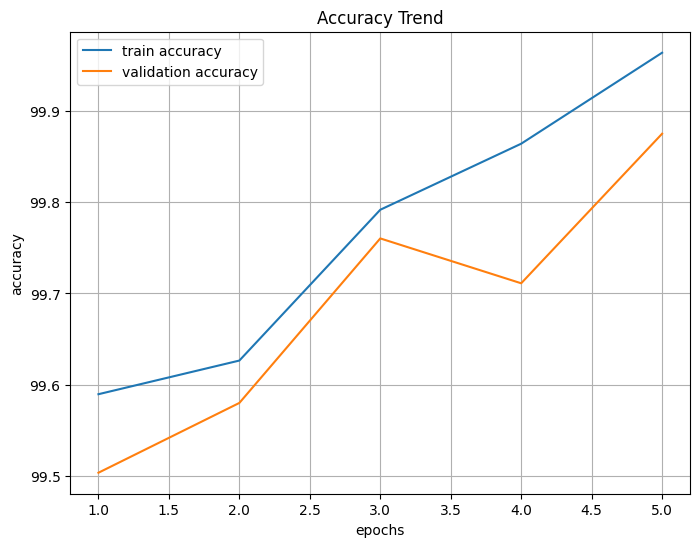

In [19]:
# Append these lists during training in the `train` function and call:
plot_training_curves(train_loss, valid_loss, train_acc, valid_acc, n_epochs)


In [20]:
def evaluate_model(loader, model, device, criterion=None):
    """
    Evaluate the model on a dataset loader (validation or test).

    Parameters:
        loader (DataLoader): The dataset loader (valid_loader or test_loader).
        model (nn.Module): The trained model.
        device (torch.device): The device to run the model on.
        criterion (optional): Loss function (e.g., CrossEntropyLoss).

    Returns:
        float: Accuracy of the model on the dataset.
        float: Loss of the model on the dataset (if criterion is provided, else None).
    """
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for data, target in loader:
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            if criterion:
                loss = criterion(output, target)
                total_loss += loss.item()

            # Predictions
            _, predicted = torch.max(output, 1)
            total_samples += target.size(0)
            total_correct += (predicted == target).sum().item()

    # Calculate average loss and accuracy
    accuracy = 100 * total_correct / total_samples
    avg_loss = total_loss / len(loader) if criterion else None

    return accuracy, avg_loss


In [21]:
val_accuracy, val_loss = evaluate_model(valid_loader, model1, device, criterion)
print(f"Validation Accuracy: {val_accuracy:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


Validation Accuracy: 99.87%
Validation Loss: 0.0042


In [22]:
test_accuracy, test_loss = evaluate_model(test_loader, model1, device, criterion)
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 95.35%
Test Loss: 0.2162
